In [1]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.2 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/alexsivkovu/risks2.git

Cloning into 'risks2'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 45 (delta 14), reused 23 (delta 7), pack-reused 0
Receiving objects: 100% (45/45), 3.75 MiB | 10.18 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [1]:
%cd risks2

/content/risks2


In [134]:
import numpy as np
import pandas as pd
import datetime
import calc_factors
from calc_factors import dataset, financial_columns, calc_and_simulate_risk_factors
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.stattools import adfuller
import arch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

# Пункт 5

In [3]:
# Загрузка данных
dataset = pd.read_excel('dataset_coupons.xlsx')
# Нужные столбцы
financial_columns = [
    'close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
    'close_AFKS', 'close_AGRO', 'close_BRENT', 'close_EUR_RUB__TOD',
    'close_GAZP', 'close_IMOEX', 'close_LKOH', 'close_NLMK', 'close_NVTK',
    'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_RTSI', 'close_SBER',
    'close_USD000000TOD', '%_0,25y', '%_0,5y', '%_0,75y', '%_1y', '%_2y',
    '%_3y', '%_5y', '%_7y', '%_10y', '%_15y', '%_20y', '%_30y'
]
portfolio=[
    'close_AFKS', 'close_AGRO', 'close_GAZP', 'close_LKOH', 'close_NLMK',
    'close_NVTK', 'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_SBER',
    'close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
    'close_EUR_RUB__TOD', 'close_USD000000TOD'
]
# Расчет риск факторов
df_risks, dict_of_risk_simulations = calc_and_simulate_risk_factors(dt_end=datetime.date(2023, 12, 2), steps_forward=1, num_samples=1000)

In [60]:
def get_risk_factors(
    dt_end=datetime.date(2023, 12, 2),
    dataset=dataset,
    financial_columns=financial_columns
):

    dt_end_datetime = pd.to_datetime(dt_end)
    dataset = dataset[dataset['dt'] < dt_end_datetime].reset_index(drop=True)
    df_financial = dataset[financial_columns]
    ica = FastICA(n_components=10, algorithm='parallel', whiten='unit-variance', fun='logcosh', max_iter=300)
    ica_components = ica.fit_transform(df_financial)
    df_ica = pd.DataFrame(data=ica_components)
    df_ica.columns = [f'risk_factor_{i}' for i in range(len(df_ica.columns))]
    df_ica['dt'] = dataset['dt']
    df_ica = df_ica[['dt'] + [f'risk_factor_{i}' for i in range(len(df_ica.columns) - 1)]]
    dataset = dataset.merge(df_ica, how='left', on='dt')
    return dataset



def garch_simulation(df, risk_factor_col, steps_forward, num_samples):
    model = arch.arch_model(df[risk_factor_col], mean='AR', vol='Garch', p=10, o=0, q=10)
    res = model.fit(disp='off')
    sim_data = res.forecast(horizon=steps_forward, method='simulation')
    means = sim_data.mean.iloc[0].values
    variances = sim_data.variance.iloc[0].values
    simulated_data = np.zeros((num_samples, steps_forward))
    for i in range(steps_forward):
        std_dev = np.sqrt(variances[i])
        simulated_data[:, i] = np.random.normal(means[i], std_dev, num_samples)
    return simulated_data



def calc_and_simulate_risk_factors(
    dt_end=datetime.date(2023, 12, 2),
    steps_forward=1,
    num_samples=1000,
    dataset=dataset,
    financial_columns=financial_columns
):

    df_risks = get_risk_factors(dt_end=dt_end, dataset=dataset, financial_columns=financial_columns)
    df = df_risks[[f'risk_factor_{i}' for i in range(10)]].copy()
    df.index = df_risks['dt']
    dict_of_risk_simulations = {}
    for risk_factor_col in df.columns:
        dict_of_risk_simulations[risk_factor_col] = garch_simulation(df, risk_factor_col, steps_forward=steps_forward, num_samples=num_samples)
    return df_risks, dict_of_risk_simulations



def rebalance_portfolio(current_prices, target_investment):
    rebalanced_quantities = {}
    for asset, target_value in target_investment.items():
        rebalanced_quantities[asset] = target_value / current_prices[asset]
    return rebalanced_quantities



def calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights):
    dfr = df_risks[[i for i in df_risks.columns if i.find('risk_factor') == 0]]
    rs = pd.DataFrame({k: v[:, -1] for k, v in risk_simulations.items()})
    new_prices = {}
    for col in portfolio:
        GB = GradientBoostingRegressor()
        GB.fit(dfr, df_risks[col])
        new_prices[col] = GB.predict(rs)
    return pd.DataFrame(new_prices).T.apply(lambda col: col * pd.Series(initial_quantities).loc[portfolio]).sum().values



def calculate_var_es(portfolio_values, var_confidence=0.99, es_confidence=0.975):
    var_value = np.percentile(portfolio_values, (1 - var_confidence) * 100)
    var_for_es_value = np.percentile(portfolio_values, (1 - es_confidence) * 100)
    es_value = portfolio_values[portfolio_values <= var_for_es_value].mean()
    return var_value, es_value

In [61]:
# Определение начальных условий
dt_end = datetime.date(2023, 12, 2)
steps_forward_1 = 1
steps_forward_10 = 10
num_samples = 1000
initial_prices = dataset[dataset['dt'] == pd.to_datetime(dt_end) - pd.Timedelta(days=1)].iloc[0][financial_columns].to_dict()
initial_investment = {
    'close_B_1': 10_000_000,
    'close_B_2': 10_000_000,
    'close_B_3': 10_000_000,
    'close_B_4': 10_000_000,
    'close_B_5': 10_000_000,

    'close_AFKS': 1_000_000,
    'close_AGRO': 1_000_000,
    'close_GAZP': 1_000_000,
    'close_LKOH': 1_000_000,
    'close_NLMK': 1_000_000,
    'close_NVTK': 1_000_000,
    'close_PLZL': 1_000_000,
    'close_ROSN': 1_000_000,
    'close_RTKM': 1_000_000,
    'close_SBER': 1_000_000,

    'close_EUR_RUB__TOD': 100_000_000,
    'close_USD000000TOD': 100_000_000,

    'close_BRENT': 0,
    'close_IMOEX': 0,
    'close_RTSI': 0,
    '%_0,25y': 0,
    '%_0,5y': 0,
    '%_0,75y': 0,
    '%_1y':0,
    '%_2y': 0,
    '%_3y': 0,
    '%_5y': 0,
    '%_7y': 0,
    '%_10y': 0,
    '%_15y': 0,
    '%_20y': 0,
    '%_30y': 0

}
initial_quantities = rebalance_portfolio(initial_prices, initial_investment)

In [62]:
# Симуляции и расчет для горизонта 1 день
df_risks, risk_simulations = calc_and_simulate_risk_factors(
    dt_end=dt_end,
    steps_forward=steps_forward_1,
    num_samples=num_samples,
    dataset=dataset,
    financial_columns=financial_columns
)
portfolio_values_1 = calculate_portfolio_values(
    df_risks,
    risk_simulations,
    initial_prices,
    initial_quantities
)
var_1, es_1 = calculate_var_es(portfolio_values_1)

print(f"1-дневный VaR (99%): {var_1}")
print(f"1-дневный ES (97.5%): {es_1}")

1-дневный VaR (99%): 218810395.46952158
1-дневный ES (97.5%): 219009107.00018528


In [63]:
# Симуляции и расчет для горизонта 10 дней
df_risks, risk_simulations = calc_and_simulate_risk_factors(
    dt_end=dt_end,
    steps_forward=steps_forward_10,
    num_samples=num_samples,
    dataset=dataset,
    financial_columns=financial_columns
)
portfolio_values_10 = calculate_portfolio_values(
    df_risks,
    risk_simulations,
    initial_prices,
    initial_quantities
)
var_10, es_10 = calculate_var_es(portfolio_values_10)

print(f"10-дневный VaR (99%): {var_10}")
print(f"10-дневный ES (97.5%): {es_10}")

10-дневный VaR (99%): 216521603.0270886
10-дневный ES (97.5%): 216239334.914183


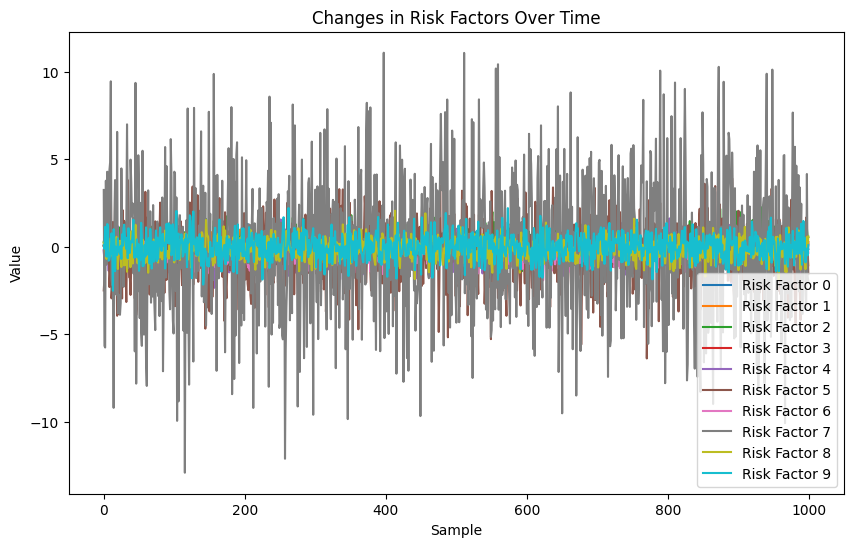

In [65]:
# Визуализация изменений в стоимости портфеля за каждый день симуляции
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(np.arange(num_samples), risk_simulations[f'risk_factor_{i}'][:, -1], label=f'Risk Factor {i}')
plt.title('Changes in Risk Factors Over Time')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

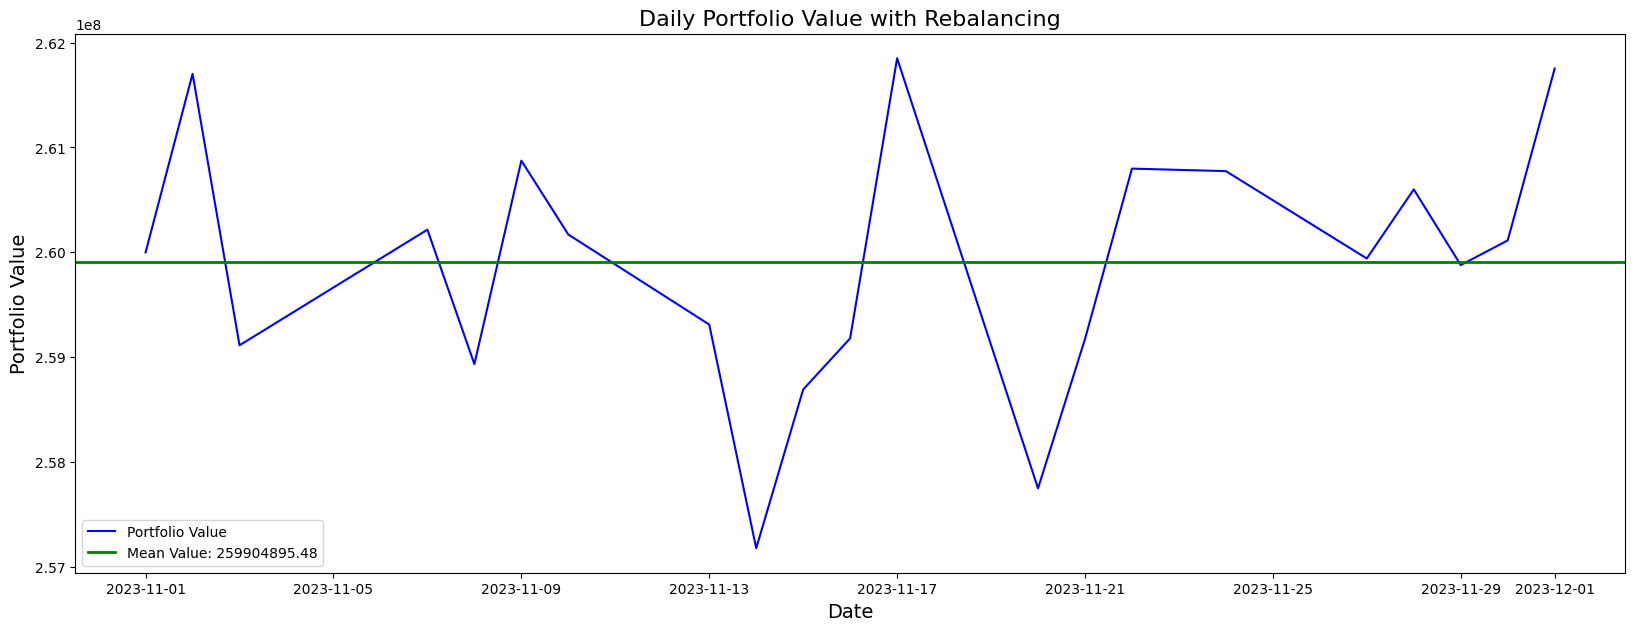

In [66]:
# Функция для симуляции ежедневной ребалансировки портфеля
def simulate_daily_rebalance(dataset, start_date, end_date, initial_investment):
    portfolio_values = []
    initial_prices = dataset[dataset['dt'] == pd.to_datetime(start_date)].iloc[0][financial_columns].to_dict()
    rebalanced_quantities = rebalance_portfolio(initial_prices, initial_investment)

    for date in pd.date_range(start=start_date, end=end_date):
        if date not in dataset['dt'].values:
            continue

        current_prices = dataset[dataset['dt'] == date].iloc[0][financial_columns].to_dict()
        portfolio_value = sum(rebalanced_quantities[asset] * current_prices[asset] for asset in portfolio)
        portfolio_values.append((date, portfolio_value))

        rebalanced_quantities = rebalance_portfolio(current_prices, initial_investment)

    return portfolio_values

# Задание начальной и конечной даты для анализа
start_date = '2023-11-01'
end_date = '2023-12-01'

# Симуляция ежедневной ребалансировки портфеля
portfolio_values = simulate_daily_rebalance(dataset, start_date, end_date, initial_investment)
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Date', 'PortfolioValue'])

plt.figure(figsize=(20, 7))
sns.lineplot(data=portfolio_values_df, x='Date', y='PortfolioValue', color='blue', label='Portfolio Value')
mean_value = portfolio_values_df['PortfolioValue'].mean()
plt.axhline(y=mean_value, color='green', linestyle='-', linewidth=2, label=f'Mean Value: {mean_value:.2f}')
plt.title('Daily Portfolio Value with Rebalancing', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value', fontsize=14)
plt.legend()
plt.show()

### Результаты пункта 5 ###
* Построена выборка из распределения риск-факторов на горизонте оценки риска - это реализовано в функции `calc_and_simulate_risk_factors`.
* По выборке значений риск-факторов построена выборка стоимостей портфеля - это реализовано в функции `calculate_portfolio_values`.
* Ребалансировка активов, чтобы сохранить пропорции, указанные в условии, осуществляется ежедневно через расчет новых цен на основе симуляций.

# Пункт 6

In [67]:
from scipy.stats import binom_test
from tqdm import tqdm

In [256]:
# Cостав портфелей
portfolios = dict(
    portfolio=[
        'close_AFKS', 'close_AGRO', 'close_GAZP', 'close_LKOH', 'close_NLMK',
        'close_NVTK', 'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_SBER',
        'close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
        'close_EUR_RUB__TOD', 'close_USD000000TOD'
    ],
    shares=[
        'close_AFKS', 'close_AGRO', 'close_GAZP', 'close_LKOH', 'close_NLMK',
        'close_NVTK', 'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_SBER'
    ],
    bonds=['close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5'],
    currencies=['close_EUR_RUB__TOD', 'close_USD000000TOD']
)



# Добавляем к функции из п.5 детализацию до (под)портфеля
def calculate_portfolio_values_detailed(
    df_risks,
    risk_simulations,
    initial_prices,
    portfolio_weights,
    portfolios=portfolios
):

    dfr = df_risks[[i for i in df_risks.columns if i.find('risk_factor') == 0]]
    rs = pd.DataFrame({k: v[:, -1] for k, v in risk_simulations.items()})
    new_prices = {}
    for col in portfolio:
        GB = GradientBoostingRegressor()
        GB.fit(dfr, df_risks[col])
        new_prices[col] = GB.predict(rs)
    portfolio_values = pd.DataFrame(new_prices).T.apply(lambda col: col * pd.Series(initial_quantities).loc[portfolio])
    return {p: portfolio_values.loc[assets].sum().values for p, assets in portfolios.items()}



# Добавляем к функции из п.5 детализацию до (под)портфеля
def calculate_var_detailed(
    portfolio_values,
    var_confidence=0.99,
    portfolios=portfolios
):
    return {key: np.percentile(portfolio_values[key], (1 - var_confidence) * 100) for key in portfolio_values.keys()}

In [169]:
# Отбираем торговые дни 2023
backtest_dt = dataset.dt[dataset.dt.dt.year == 2023].to_frame()
# Каждому торговому дню ставим в пару предыдущий (нужен для взятия стартовых цен)
backtest_dt['lag'] = backtest_dt.shift()
# Заполняем пропущенный лаг для первого торгового дня в 2023
backtest_dt.lag = backtest_dt.lag.fillna(dataset.dt[dataset.dt.dt.year == 2022].max())
# Каждому торговому дню ставим в пару Т+10 день (нужен для взятия фактических цен на горизонте 10 дней)
# Здесь берем 9, потому что функция calculate_portfolio_value не учитывает сам день, а берет все дни до него
backtest_dt['lead_10'] = dataset.dt.shift(-9)
# Дропаем даты, для которых не доступны данные для сверки
backtest_dt = backtest_dt.dropna()

# Форма для записи результатов симуляций
backtest_results = {
    key: pd.DataFrame(
        data=np.zeros((2, 2)),
        index=[1, 10],
        columns=['success', 'trials']
    ) for key in portfolios.keys()
}



# Проводим расчет п.5
# На каждый торговый день 2023
for i in tqdm(backtest_dt.index[:10]):

    # Определяем начальные условия
    dt_end = backtest_dt.loc[i, 'dt']
    steps_forward_1 = 1
    steps_forward_10 = 10
    num_samples = 1000
    initial_prices = dataset[dataset['dt'] == backtest_dt.loc[i, 'lag']].iloc[0][financial_columns].to_dict()

    # Проводим ребалансировку портфеля
    portfolio_quantities = rebalance_portfolio(initial_prices, initial_investment)
    pw = {p: {col: w for col, w in portfolio_quantities.items() if col in assets} for p, assets in portfolios.items()}

    # Определяем фактическую стоимость портфеля
    portfolio_prices_1 = {p: dataset[dataset.dt == dt_end][assets].iloc[0] for p, assets in portfolios.items()}
    portfolio_prices_10 = {p: dataset[dataset.dt == backtest_dt.loc[i, 'lead_10']][assets].iloc[0] for p, assets in portfolios.items()}
    portfolio_value_1 = {p: (portfolio_prices_1[p] * pd.Series(pw[p])).sum() for p in portfolios.keys()}
    portfolio_value_10 = {p: (portfolio_prices_10[p] * pd.Series(pw[p])).sum() for p in portfolios.keys()}


    # Симуляции и расчет для горизонта 1 день
    df_risks, risk_simulations = calc_and_simulate_risk_factors(
        dt_end=dt_end,
        steps_forward=steps_forward_1,
        num_samples=num_samples,
        dataset=dataset,
        financial_columns=financial_columns
    )
    portfolio_values_1 = calculate_portfolio_values_detailed(
        df_risks,
        risk_simulations,
        initial_prices,
        portfolio_quantities
    )
    var_1 = calculate_var_detailed(portfolio_values_1)

    # Симуляции и расчет для горизонта 10 дней
    df_risks, risk_simulations = calc_and_simulate_risk_factors(
        dt_end=dt_end,
        steps_forward=steps_forward_10,
        num_samples=num_samples,
        dataset=dataset,
        financial_columns=financial_columns
    )
    portfolio_values_10 = calculate_portfolio_values_detailed(
        df_risks,
        risk_simulations,
        initial_prices,
        portfolio_quantities
    )
    var_10 = calculate_var_detailed(portfolio_values_10)

    # Записываем результат симуляции
    for p in portfolios.keys():
        backtest_results[p].loc[:, 'trials'] += 1
        backtest_results[p].loc[1, 'success'] += int(portfolio_value_1[p] >= var_1[p])
        backtest_results[p].loc[10, 'success'] += int(portfolio_value_10[p] >= var_10[p])

print('\nЗавершено успешно!')

 40%|████      | 4/10 [01:39<02:31, 25.20s/it]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
100%|██████████| 10/10 [04:05<00:00, 24.56s/it]


Завершено успешно!


In [170]:
# Проверяем гипотезу о корректности оценки - проводим двухсторонний тест Бернулли
# (По сути мы последовательно проводим независимые испытания с бинарным исходом (норма/пробитие) с известной вероятностью успеха 0.99)
# (Ошибаться нам невыгодно в обе стороны, поэтому тест двухсторонний)
alternative = 'two-sided'
significance_level = 0.05



# Для каждого портфеля
for p in backtest_results.keys():

    # Для каждого горизонта
    for i in backtest_results[p].index:

        # Проводим тест
        pv = binom_test(
            backtest_results[p].loc[i, 'success'],
            backtest_results[p].loc[i, 'trials'],
            p=0.99,
            alternative=alternative
        )
        # Сохраняем p-value и вывод
        backtest_results[p].loc[i, 'p-value'] = pv
        backtest_results[p].loc[i, 'eval_correct'] = pv > significance_level

backtest_6 = pd.concat(backtest_results)
backtest_6.index.names = ('portfolio', 'horizon')
backtest_6

success  trials       p-value eval_correct
portfolio  horizon                                            
portfolio  1           10.0    10.0  1.000000e+00         True
           10          10.0    10.0  1.000000e+00         True
shares     1           10.0    10.0  1.000000e+00         True
           10          10.0    10.0  1.000000e+00         True
bonds      1            0.0    10.0  1.000000e-20        False
           10           0.0    10.0  1.000000e-20        False
currencies 1           10.0    10.0  1.000000e+00         True
           10          10.0    10.0  1.000000e+00         True

In [92]:
backtest_6.to_excel('backtest_results_6.xlsx')